# CTR_DRBG

Counter mode Deterministic Random Bit Generator SP 800-90A Rev. 1

## Código base

## Método de generación de distribución

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from collections import Counter

def graficar_histograma_bytes(values, filename="random_bits_histogram.png", aditional_title=""):
    # Paso 1: Calcular frecuencias
    byte_counts = Counter(values)
    most_freq_byte = max(byte_counts, key=byte_counts.get)
    least_freq_byte = min(byte_counts, key=byte_counts.get)
    most_freq_density = byte_counts[most_freq_byte] / len(values)
    least_freq_density = byte_counts[least_freq_byte] / len(values)

    # Paso 2: Crear histograma
    plt.figure(figsize=(10, 6))
    count, bins, _ = plt.hist(values, bins=256, density=True, alpha=0.6, color='skyblue', label='Frequency')

    # Paso 3: Superponer distribución normal
    mu, sigma = np.mean(values), np.std(values)
    x = np.linspace(0, 255, 256)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal Distribution\nμ={mu:.2f}, σ={sigma:.2f}')

    # Paso 4: Resaltar el más y menos frecuente
    plt.axvline(most_freq_byte, color='green', linestyle='--', linewidth=1.5, label=f'Most Frequent: {most_freq_byte}')
    plt.text(most_freq_byte + 1, most_freq_density,
             f'{most_freq_byte}\nCount: {byte_counts[most_freq_byte]}',
             color='green', fontsize=9, ha='left', va='bottom')

    plt.axvline(least_freq_byte, color='purple', linestyle='--', linewidth=1.5, label=f'Least Frequent: {least_freq_byte}')
    plt.text(least_freq_byte + 1, least_freq_density,
             f'{least_freq_byte}\nCount: {byte_counts[least_freq_byte]}',
             color='purple', fontsize=9, ha='left', va='bottom')

    # Paso 5: Configuración final
    total_bytes = len(values)
    plt.title(f'Histogram of {total_bytes:,} Random Bytes\nwith Normal Distribution Overlay\n{aditional_title}')
    plt.xlabel('Byte Value (0–255)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Paso 6: Guardar y mostrar
    plt.savefig(filename, dpi=300)
    plt.show()

In [2]:
def bits_a_bytes(bit_string):
    # Asegurar que la longitud sea múltiplo de 8
    if len(bit_string) % 8 != 0:
        raise ValueError("La cadena de bits debe tener una longitud múltiplo de 8.")
    
    # Convertir cada grupo de 8 bits a entero
    return [int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8)]

[108, 101, 47]


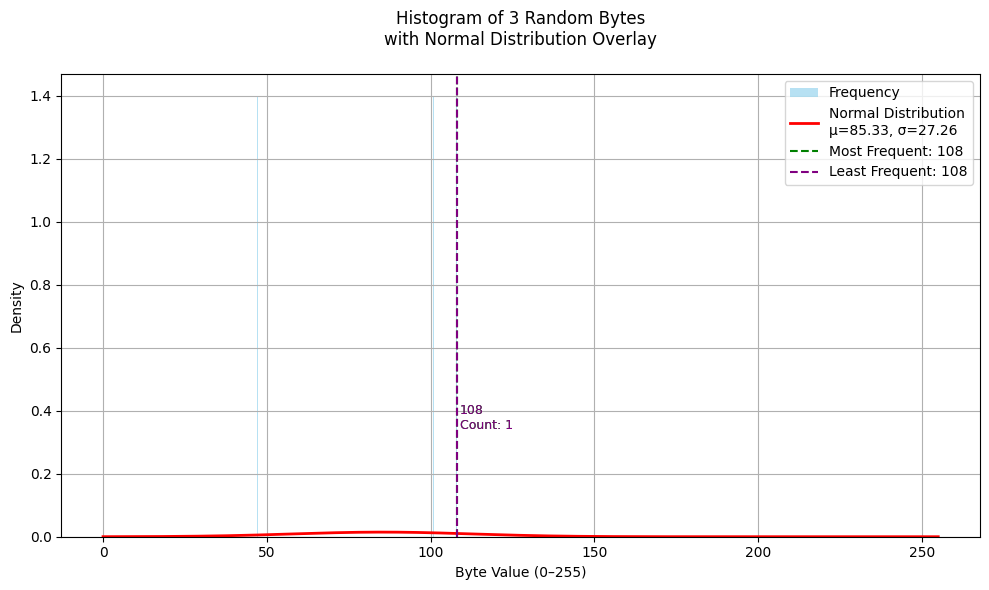

In [3]:
## Ejemplo de uso
bit_string = "011011000110010100101111"
bytes_list = bits_a_bytes(bit_string)
print(bytes_list)  # Ejemplo de salida: [108, 101, 47]

graficar_histograma_bytes(bytes_list, "histograma.png")

In [4]:
def save_bytes_to_file(values, filename="random.txt"):
    # Abrir archivo en modo escritura
    with open(filename, "w") as f:
        for byte in values:
            # Convertir cada byte a una cadena de 8 bits y escribirla al archivo
            bits = format(byte, '08b')  # Por ejemplo: 5 -> '00000101'
            f.write(bits)

### Función CTR_DRBG

El siguiente es el algoritmo base, que implementa CTR_DRBG

In [5]:
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend


class CTR_DRBG:
    def __init__(self, seed=None, key_size=32, reseed_interval=10000):
        self.key_size = key_size  # 32 bytes = AES-256
        self.backend = default_backend()
        self.reseed_interval = reseed_interval
        self.generate_counter = 0

        if seed is None:
            seed = os.urandom(self.key_size)
        #print(f"Seed: {seed.hex()}")
        self.key = seed[:self.key_size]
        self.V = int.from_bytes(os.urandom(16), 'big') # 128 bits for AES block size

    def _increment_counter(self):
        self.V = (self.V + 1) % (1 << 128)

    def _aes_encrypt(self, block_bytes):
        cipher = Cipher(algorithms.AES(self.key), modes.ECB(), backend=self.backend)
        encryptor = cipher.encryptor()
        return encryptor.update(block_bytes) + encryptor.finalize()

    def _update_state(self, additional_input=None):
        temp = b""
        v_temp = self.V
        while len(temp) < self.key_size + 16:
            input_block = v_temp.to_bytes(16, 'big')
            temp += self._aes_encrypt(input_block)
            v_temp = (v_temp + 1) % (1 << 128)

        if additional_input:
            temp = bytes(x ^ y for x, y in zip(temp, additional_input))

        self.key = temp[:self.key_size]
        self.V = int.from_bytes(temp[self.key_size:self.key_size + 16], 'big')

    def set_seed(self, seed):
        self.key = seed[:self.key_size]

    def reseed(self, entropy_input=None):
        if entropy_input is None:
            entropy_input = os.urandom(self.key_size + 16)
        self._update_state(entropy_input)
        self.generate_counter = 0

    def generate(self, num_bytes, additional_input=None):
        if self.generate_counter >= self.reseed_interval:
            self.reseed()

        if additional_input:
            self._update_state(additional_input)

        output = b""
        while len(output) < num_bytes:
            input_block = self.V.to_bytes(16, 'big')
            output += self._aes_encrypt(input_block)
            self._increment_counter()

        self._update_state(additional_input)
        self.generate_counter += 1
        return output[:num_bytes]

    def get_random_bits_from_bytes(self, random_bytes):
        return ''.join(f'{byte:08b}' for byte in random_bytes)

## Ejemplo generación un pseudo número aleatorio

In [6]:
drbg = CTR_DRBG(seed=bytes("5872a5d78596fc5be269b8dc4876d0c68fa7a1499f1e4fedcb2c75f8bca8d8d8", 'utf-8'))

# Generar 64 bytes aleatorios
random_bytes = drbg.generate(64)
print("Bytes aleatorios (hex):", random_bytes.hex())

bit_string = drbg.get_random_bits_from_bytes(random_bytes)
print("Bits aleatorios:", bit_string)
print("Longitud en bits:", len(bit_string))


Bytes aleatorios (hex): 0e1aab7813a3d283d98fce04b7def620a7200edc9e3acb4bc8b3cd594f853104417f9b499dcfbcee27e8cb1daaec240b588634ccbd9fded3e960ee61db63af11
Bits aleatorios: 00001110000110101010101101111000000100111010001111010010100000111101100110001111110011100000010010110111110111101111011000100000101001110010000000001110110111001001111000111010110010110100101111001000101100111100110101011001010011111000010100110001000001000100000101111111100110110100100110011101110011111011110011101110001001111110100011001011000111011010101011101100001001000000101101011000100001100011010011001100101111011001111111011110110100111110100101100000111011100110000111011011011000111010111100010001
Longitud en bits: 512


## Modelos de generación de números aleatorios

### Semilla Random de el lenguaje de programación

Esta semilla se genera de forma aletoria a través del uso de la función random del lenguaje de programación python, se asume que es una fuente lo suficientemente aleatoria para generar los valores que serviran como fuente para evaluar la técnica de generación de bit aleatorio

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from collections import Counter

# Assuming CTR_DRBG is already defined and initialized
drbg = CTR_DRBG()

# Step 1: Generate 50 million bits (50,000,000 bits = 6,250,000 bytes)
random_bytes = drbg.generate(6_250_000)

# Step 2: Convert bytes to integers in range 0–255
values = list(random_bytes)

Guardar los bytes

In [8]:
save_bytes_to_file(values, "random_bits_CTR_DRBG_seed_python_random.txt")

### Semilla Secuencia de desde 1 a 50 000 000

In [9]:
# Asumiendo que tienes la clase CTR_DRBG correctamente definida
def numero_a_32_bytes(n):
    return n.to_bytes(32, byteorder='big')

# Generar 1 byte por cada semilla en el rango 1 a 1,000,000
random_bytes = []
drbg = CTR_DRBG()
for i in range(1, 6_250_001 ):
    drbg.set_seed(seed=numero_a_32_bytes(i))
    byte = drbg.generate(1)[:]
    random_bytes.append(byte)

print("Total bytes generados:", len(random_bytes))
values = list(random_bytes)

Total bytes generados: 6250000


In [10]:
values = list(random_bytes)

flat_bits = [bit for byte in values for bit in byte]

save_bytes_to_file(flat_bits, "secuentialSeedFrom0_To_100M_CTR_DRBG.txt")

In [11]:
len(flat_bits)
# Graficar el histograma

6250000

## Generación histograma por tipo de generación de números aleatorios

In [12]:
def leer_string_de_archivo(nombre_archivo):
    with open(nombre_archivo, 'r', encoding='utf-8') as archivo:
        contenido = archivo.read()
    return contenido

### Gráfica - Semilla Random de el lenguaje de programación

In [13]:
texto = leer_string_de_archivo("random_bits_CTR_DRBG_seed_python_random.txt")
print("Primeros 100 caractéres",texto[:100])  # Muestra los primeros 100 caracteres del archivo

Primeros 100 caractéres 1111101110110101011011110001010111110011001011111010100000010000010110101011010111010000101111111011


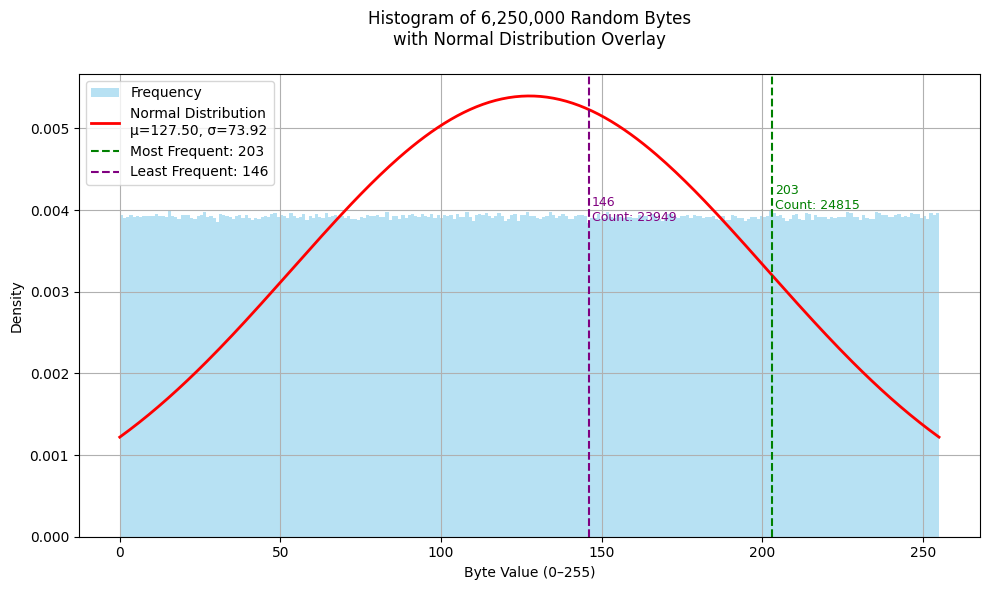

In [14]:
bytes_list = bits_a_bytes(texto)
graficar_histograma_bytes(bytes_list, "random_bits_CTR_DRBG_seed_python_random.png")

### Gráfica - Semilla Secuencia de desde 1 a 50 000 000

In [15]:
texto = leer_string_de_archivo("secuentialSeedFrom0_To_100M_CTR_DRBG.txt")
print("Primeros 100 caractéres",texto[:100])  # Muestra los primeros 100 caracteres del archivo

Primeros 100 caractéres 1000101010001111101101010011001001011010010100100010100000010101011110111111000110010010110010111111


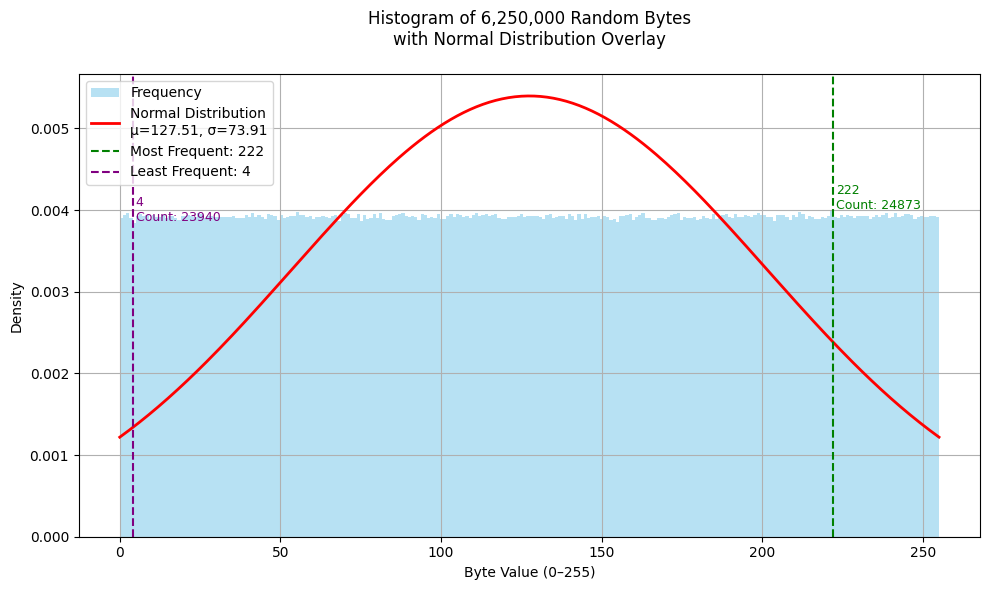

In [16]:
bytes_list = bits_a_bytes(texto)
graficar_histograma_bytes(bytes_list, "secuentialSeedFrom0_To_100M_CTR_DRBG.png")

## Gráfica para los primeros 50 000 bytes

In [18]:
texto = leer_string_de_archivo("secuentialSeedFrom0_To_100M_CTR_DRBG.txt")
print("Primeros 100 caractéres",texto[:100])  # Muestra los primeros 100 caracteres del archivo

Primeros 100 caractéres 1000101010001111101101010011001001011010010100100010100000010101011110111111000110010010110010111111


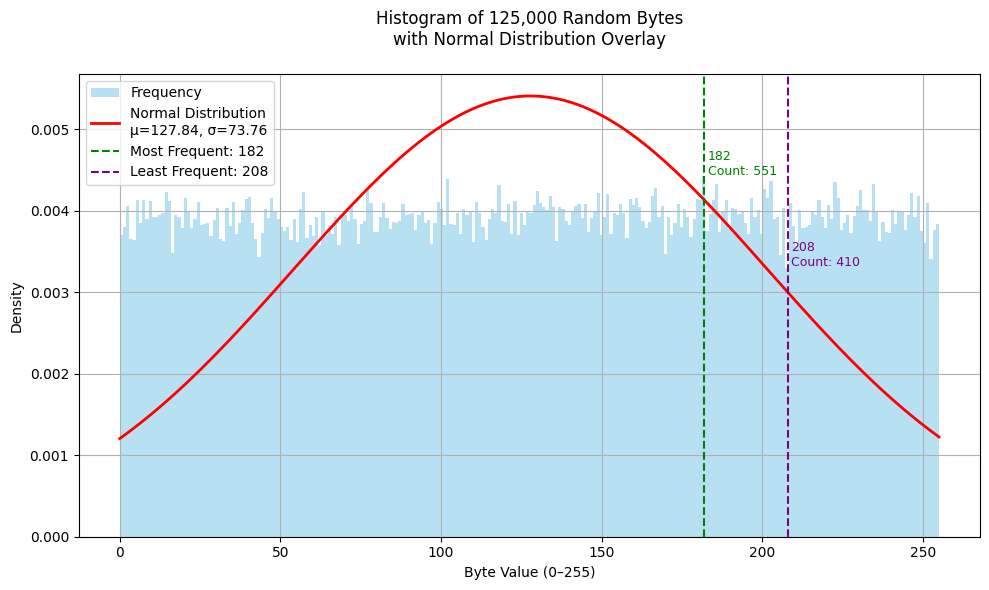

In [21]:
bytes_list = bits_a_bytes(texto[:1000000])
graficar_histograma_bytes(bytes_list, "secuentialSeedFrom0_To_50K_CTR_DRBG.png")